In [1]:
# pip install pydub noisereduce json-tricks

In [1]:
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

c:\Users\Asus\anaconda3\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

# Maximum samples count for padding purposes.

sample_lengths = []
folder_path = 'Ravdess'

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)
     
    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))       

In [3]:
# Maximum samples count for padding purposes.

sample_lengths = []
folder_path = 'RAVDESS/'

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)
    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))                   

Maximum sample length: 204288


In [4]:
import time
tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 173056 # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = 'RAVDESS/' 

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 

    # Fetch the sample rate.
      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file)) 
    # Normalize the audio to +5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 0) 
    # Transform the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)
      #print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed-- 
    # Pad for duration equalization.
      padded_x = np.pad(xt, max(0, (total_length - len(xt))), 'constant')
    # Noise reduction.
      final_x = nr.reduce_noise(padded_x, sr=sr) #updated 03/03/22
       
   # Features extraction 
      f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length)# Energy - Root Mean Square   
      f2 = librosa.feature.zero_crossing_rate(y=final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR      
      f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
      
   # Emotion extraction from the different databases
      name = file[6:8]                      

   # Filling the data lists  
      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      emotions.append(emotionfix(name)) 

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

Running time: 3.3465 minutes


In [6]:
# Determine the maximum length of sequences in `rms`
max_len = max(r.shape[1] for r in rms)

# Pad sequences in `rms` to have the same length
rms_padded = [np.pad(r, ((0, 0), (0, max_len - r.shape[1]))) for r in rms]

# Convert the list to a numpy array
rms = np.stack(rms_padded)

# Determine the maximum length of sequences in `zcr`
max_len = max(z.shape[1] for z in zcr)

# Pad sequences in `zcr` to have the same length
zcr_padded = [np.pad(z, ((0, 0), (0, max_len - z.shape[1]))) for z in zcr]

# Convert the list to a numpy array
zcr = np.stack(zcr_padded)

# Determine the maximum length of sequences in `mfcc`
max_len = max(m.shape[1] for m in mfcc)

# Pad sequences in `mfcc` to have the same length
mfcc_padded = [np.pad(m, ((0, 0), (0, max_len - m.shape[1]))) for m in mfcc]

# Convert the list to a numpy array
mfcc = np.stack(mfcc_padded)


In [7]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

# making all in equal dimensions

f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (1440, 577, 1)
RMS shape: (1440, 577, 1)
MFCCs shape: (1440, 577, 13)


In [8]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Using RBF Kernel SVM to classify the data

In [20]:
from sklearn.svm import SVC
model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

In [21]:
model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())

SVC(C=1, random_state=42)

In [22]:
# Make predictions
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))

# Evaluate performance
from sklearn.metrics import classification_report, accuracy_score
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred)*100, "%")

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.30      0.34        20
           1       0.50      0.52      0.51        44
           2       0.27      0.29      0.28        34
           3       0.26      0.15      0.19        39
           4       0.33      0.21      0.26        42
           5       0.16      0.16      0.16        32
           6       0.18      0.28      0.22        32
           7       0.38      0.51      0.44        45

    accuracy                           0.32       288
   macro avg       0.31      0.30      0.30       288
weighted avg       0.32      0.32      0.31       288

Accuracy: 31.59722222222222 %


# Using LSTM to classify the data (RNN)

In [23]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten

# Define the model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,049 (320.50 KB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 346ms/step - accuracy: 0.1144 - loss: -10.4900 - val_accuracy: 0.1528 - val_loss: -77.6278
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 336ms/step - accuracy: 0.1258 - loss: -112.2121 - val_accuracy: 0.1528 - val_loss: -222.4515
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 344ms/step - accuracy: 0.1349 - loss: -265.2657 - val_accuracy: 0.1528 - val_loss: -435.6860
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 325ms/step - accuracy: 0.1314 - loss: -512.9642 - val_accuracy: 0.1528 - val_loss: -727.9229
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 326ms/step - accuracy: 0.1184 - loss: -824.7435 - val_accuracy: 0.1528 - val_loss: -1098.5192
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step - accuracy: 0.1079 - loss: -1264.2051 - val_accuracy: 0.1528 - val_loss: -1550.9314
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 326ms/step - accuracy: 0.1270 - loss: -1765.5037 - val_accuracy: 0.1528 - val_loss: -2087.8152
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 326ms/step

# Using the RandomForestClassifier to classify the data

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred)*100, "%")

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.30      0.33        20
           1       0.57      0.73      0.64        44
           2       0.52      0.41      0.46        34
           3       0.38      0.38      0.38        39
           4       0.65      0.52      0.58        42
           5       0.38      0.47      0.42        32
           6       0.54      0.59      0.57        32
           7       0.63      0.58      0.60        45

    accuracy                           0.52       288
   macro avg       0.51      0.50      0.50       288
weighted avg       0.52      0.52      0.52       288

Accuracy: 51.736111111111114 %


# Using the XGBoost Classifier to classify the data

In [25]:
from xgboost import XGBClassifier

# Standardize features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

# Initialize and train the XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xgb_classifier.predict(X_test_scaled)

In [26]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred)*100, "%")

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.45      0.43        20
           1       0.74      0.70      0.72        44
           2       0.51      0.56      0.54        34
           3       0.34      0.41      0.37        39
           4       0.73      0.52      0.61        42
           5       0.57      0.72      0.64        32
           6       0.48      0.44      0.46        32
           7       0.66      0.60      0.63        45

    accuracy                           0.56       288
   macro avg       0.56      0.55      0.55       288
weighted avg       0.58      0.56      0.56       288

Accuracy: 55.90277777777778 %


# Using CNN to classify the data

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
def create_cnn_model(input_shape):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv1D(32, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(64, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))

    # Flatten layer
    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(8, activation='softmax'))  # Assuming 8 emotions

    return model

# Input shape should match the shape of the concatenated features
input_shape = X.shape[1:]

# Create the CNN model
cnn_model = create_cnn_model(input_shape)

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = cnn_model.fit(X, Y, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.1474 - loss: 97.8556 - val_accuracy: 0.2049 - val_loss: 2.1552
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2392 - loss: 2.0563 - val_accuracy: 0.2396 - val_loss: 1.9613
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3096 - loss: 1.7653 - val_accuracy: 0.2778 - val_loss: 1.9202
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4010 - loss: 1.6427 - val_accuracy: 0.2569 - val_loss: 2.1752
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4668 - loss: 1.4715 - val_accuracy: 0.3021 - val_loss: 1.9837
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4995 - loss: 1.3382 - val_accuracy: 0.3056 - val_loss: 2.0353
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6011 - loss: 1.1362 - val_accuracy: 0.3125 - val_loss: 2.0829
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6513 - loss: 1.0001 - val_accuracy: 0.3194 - 

In [12]:
# Evaluate the model
loss, accuracy = cnn_model.evaluate(X, Y)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy*100}%')

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9819 - loss: 0.1572  
Test Loss: 1.1297136545181274, Test Accuracy: 86.80555820465088%


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


<Figure size 1000x800 with 0 Axes>

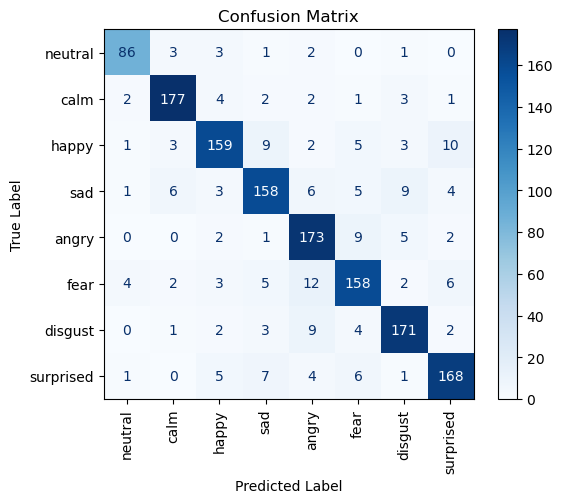

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
def create_cnn_model(input_shape):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv1D(32, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(64, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))

    # Flatten layer
    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(8, activation='softmax'))  # Assuming 8 emotions

    return model

# Input shape should match the shape of the concatenated features
input_shape = X.shape[1:]

# Create the CNN model
cnn_model = create_cnn_model(input_shape)

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = cnn_model.fit(X, Y, epochs=30, batch_size=32, validation_split=0.2)

In [14]:
# Save the CNN model
cnn_model.save("emotion_cnn_model.h5")

In [1]:
# Load the CNN model
import tensorflow as tf
loaded_model = tf.keras.models.load_model("emotion_cnn_model.h5")
print(loaded_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 575, 32)        │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 287, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 285, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 142, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 140, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 70, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 68, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       557,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,626 (2.47 MB)

 Trainable params: 647,624 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [19]:
import librosa
import numpy as np
import soundfile as sf

def preprocess_audio(audio, sr, target_length=575, n_mfcc=13):
    # Normalize audio
    audio = audio / np.max(np.abs(audio), axis=0)
    
    # Trim silence
    audio, _ = librosa.effects.trim(audio)

    # Pad or truncate to match the target length
    if len(audio) > target_length:
        audio = audio[:target_length]
    else:
        audio = np.pad(audio, (0, max(0, target_length - len(audio))), 'constant')

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    # Calculate RMS
    rms = librosa.feature.rms(y=audio)

    # Calculate ZCR
    zcr = librosa.feature.zero_crossing_rate(y=audio)

    # Stack MFCC with RMS and ZCR along the feature axis
    features = np.vstack([mfcc, rms, zcr])

    # Pad or truncate the feature matrix to match the required time steps
    if features.shape[1] < target_length:
        features = np.pad(features, ((0, 0), (0, target_length - features.shape[1])), 'constant')
    elif features.shape[1] > target_length:
        features = features[:, :target_length]

    return features.T[np.newaxis, :, :]

# Example usage
audio, sr = sf.read('temp.wav')
features = preprocess_audio(audio, sr)
print("Shape of processed features:", features.shape)

Shape of processed features: (1, 575, 15)


In [20]:
prediction = loaded_model.predict(features)
emotion_index = np.argmax(prediction)
emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
predicted_emotion = emotions[emotion_index]
print("Predicted emotion:", predicted_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted emotion: disgust


In [ ]:
# 